<a href="https://colab.research.google.com/github/kschuler/analyses/blob/master/inconinput_austinnewport_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# InconInput Austin & Newport Analysis

*by Katie Schuler*

This is my analysis for the InconInput Austin & Newport paper. I conducted it on 7/18/2019, after Lissa finished a final draft of the paper and asked me to include a few additional statistics that were missing from the paper. Note that all links are in Google Drive and accessible only to Katie and Lissa.


*Note that I was initially worried because we only have Alison's raw data, and I'd have to re-do her preprocessing steps (especially for the Production Test portion). But Lissa pointed out that we could probably do what she wanted with just the means and sems reported in the text, plus an analysis of the rating data. So, I set out to do that.*








## Setting up


### Load libraries

As always, we first load the libraries we will need to concuct the analysis

In [0]:
# install required packages
install.packages('BSDA')

In [0]:
# load required libraries
library(readr)
library(tidyr)
library(dplyr)
library(knitr)
library(ggplot2)
library(broom)
library(purrr)
library(BSDA)



### Load production data
I started by creating a sheet (in my summary of Alison's data) called "[DataSummaryKatie](https://docs.google.com/spreadsheets/d/1cqPU4l4fGeNN4TbZ0Q_FD6m0Gfm4SPEKa55YrLHTbBA/edit#gid=1457778822)". In this sheet, I included all of the data that was reported for each experiment in Lissa's draft of the paper. I obtained all values **from the text of the paper** ([this version](https://drive.google.com/file/d/1_aGfZArmCAb81rhBRXxTk-YO28pycJw5/view?usp=sharing)).


In [0]:
# read in means and sems from paper and add columns we need for ttest (sd computed from se)
data_paper <- read_csv('inconinput-austinnewport-data - DataSummaryKatie.csv') %>%
  mutate(n = n_subjs_a, mean = mean_dom, sd = se_dom * sqrt(n_subjs_a), se = se_dom, df = n_subjs_a - 1) %>%
  select(experiment_paper, age_group, condition, n, df, mean, sd, se)

In [6]:
# let's see data for usage of dominant form in each experiment
data_paper %>% kable



|experiment_paper |age_group   |condition    |  n| df|  mean|        sd|   se|
|:----------------|:-----------|:------------|--:|--:|-----:|---------:|----:|
|Experiment 1     |adult       |consistent   |  8|  7| 100.0|  0.000000| 0.00|
|Experiment 1     |adult       |inconsistent |  9|  8|  67.4| 11.400000| 3.80|
|Experiment 1     |young child |consistent   |  5|  4| 100.0|  0.000000| 0.00|
|Experiment 1     |young child |inconsistent | 10|  9|  90.1| 18.024983| 5.70|
|Experiment 2     |adult       |consistent   |  7|  6|  69.8|  3.439477| 1.30|
|Experiment 2     |young child |consistent   |  8|  7|  64.5| 17.932228| 6.34|
|Experiment 3     |adult       |inconsistent | 12| 11|  61.8| 11.362253| 3.28|
|Experiment 3     |older child |inconsistent |  7|  6|  68.2| 24.526115| 9.27|
|Experiment 3     |young child |inconsistent |  7|  6|  82.7| 23.679474| 8.95|
|Experiment 4     |adult       |inconsistent |  8|  7|  44.6|  9.842926| 3.48|
|Experiment 4     |older child |inconsistent | 10|

I double-checked, and these all match the values reported in the paper.


### Load rating data
Rating data exists for Experiment 3 (60-40) and Experiment 4 (40-20-4). We only have access to Alison's trial-by-trial rating data, so my next step was to get means and se (for both raw and z-scored) ratings for each experiment in the paper. To do this, I imported Alison's [SubjectTracking](https://docs.google.com/spreadsheets/d/1cqPU4l4fGeNN4TbZ0Q_FD6m0Gfm4SPEKa55YrLHTbBA/edit#gid=1419531819) sheet and her raw [RatingTest](https://docs.google.com/spreadsheets/d/1cqPU4l4fGeNN4TbZ0Q_FD6m0Gfm4SPEKa55YrLHTbBA/edit#gid=1072014936) data. I need the subject tracking sheet because it contains information about the age of the child (what age group they are in) and also about whether or not their data was included in analysis. The rating data only includes subject ID numbers.

In [0]:
# read in subject tracking data and rating data
subj_tracking <- read_csv('inconinput-austinnewport-data - SubjectTracking.csv') %>%
  select(Subject, experiment, marked_include, age, notes_tracking)
rating_data <- read_csv('inconinput-austinnewport-data - RatingTest (1).csv')

# merge by subject and add age_group variable
data <- left_join(rating_data, subj_tracking, by = c("Subject")) %>%
  mutate(age_group = ifelse(age < 7 , 'young child', ifelse(age < 10, 'older child', 'adult')))

Next I wanted to check that everyone in Experiment 3 (60-40) and Experiment 4 (40-20-4) should be inluded in rating analysis. 

1.   The first way I did this was to use the "marked_include" value on Alison' s Subject Tracking sheet (she uses x for included and ~ for excluded). All of the participants who have rating data for these experiments are marked "include" (x).
2.   Next, I checked whether the number of participants in each condition matched with what we included in the paper.  It doesn't. I do not know how to resolve this.
  *   In 60-40, there is rating data for 12 older children, 10 younger children, and 0 adults, but the paper lists 12 adults, 8 older children, and 10 younger children (with final analysis including 12 adults, 7 older children, and 7 younger children)
  *   In 40-20-4, there is rating data for 8 adults, 8 older children, and 11 younger children. The paper lists 8 adults, 10 older children and 10 younger children (with final analysis including 8 adults, 10 older children, and 9 young children)
3. Then, I checked whether any participants selected all the same value on the rating test. No-one did so I left them all in.
4. Finally, inspecting 40-20-4 resulted in a different problem: many of the children did not have the "correct" rating data. They seem to have been run in a different rating test all together. This is especially true of the older children (only 2 got the correct version of the rating test according to the raw data).


*Note: I discussed all this on the phone with Lissa on 7/18/2019. She said that we should consider Alison's plot to have the right data, and, since the rating data isn't terribly important (we are really arguing there is not much to interpret), we can just use and include all of the data we have for the correct rating test. I did so, and generated plots from this data. They turned out to match Alison's very closely, so we went ahead with that.




In [25]:
# check whether anyone was excluded from either experiment on Alison's subject tracking sheet
# check this value the n against the ns reported in the paper
data %>% filter(Distribution %in% c("60-40", "40-20-4")) %>% group_by(Distribution, age_group, marked_include) %>%
  summarise(n = n_distinct(Subject)) %>% kable



|Distribution |age_group   |marked_include |  n|
|:------------|:-----------|:--------------|--:|
|40-20-4      |adult       |x              |  8|
|40-20-4      |older child |x              |  8|
|40-20-4      |young child |x              | 11|
|60-40        |adult       |x              |  8|
|60-40        |older child |x              | 12|
|60-40        |young child |x              | 10|

In [26]:
# check whether anyone selected all the same value (e.g. all 5) on the rating test
data %>% filter(Distribution %in% c("60-40", "40-20-4")) %>% group_by(Distribution, age_group, Subject) %>%
  summarise(n_distinct = n_distinct(Rating)) %>% 
  group_by(Distribution, age_group, n_distinct) %>%
  summarise(n_subjs = n_distinct(Subject)) %>%
  kable



|Distribution |age_group   | n_distinct| n_subjs|
|:------------|:-----------|----------:|-------:|
|40-20-4      |adult       |          3|       1|
|40-20-4      |adult       |          4|       7|
|40-20-4      |older child |          3|       2|
|40-20-4      |older child |          4|       6|
|40-20-4      |young child |          2|       2|
|40-20-4      |young child |          3|       2|
|40-20-4      |young child |          4|       7|
|60-40        |adult       |          2|       1|
|60-40        |adult       |          3|       2|
|60-40        |adult       |          4|       5|
|60-40        |older child |          2|       2|
|60-40        |older child |          3|       2|
|60-40        |older child |          4|       8|
|60-40        |young child |          3|       1|
|60-40        |young child |          4|       9|

Lastly, I grouped all of the 'novel' trial types together (novb, novt, novc, and novv) into one category "nov" to match the way Alison plotted the data. Then, I generated a z_score for the participants. 

In [0]:
# group all 'novel' trials together and then normalize (z-score)
data_normed <- filter(data, Distribution %in% c("60-40", "40-20-4")) %>%
  mutate(`Sentence Manipulation` = ifelse(`Sentence Manipulation` %in% c("novb", "novt", "novc", "novv"), 'nov', `Sentence Manipulation`)) %>%
  group_by(Distribution, Subject) %>%
  mutate(z_score = scale(Rating))
  

Now that all of the data has been loaded and normalized (for rating data), we can move on to doing the stats.

## Experiment 1

No stats were needed for Experiment 1 (Alison had included them all), but I ran some ttests anyway to make sure the way I am doing things is matching up with the way Alison did things.

Alison's reported ttests (for inconsistent language):

*   Adults compared to input: t(8)=0.199, p=0.848
*   Children compared to input: t(8)-4.11, p=0.003



In [7]:
# let's see the data for this experiment
data_paper %>% filter(experiment_paper == "Experiment 1") %>% kable



|experiment_paper |age_group   |condition    |  n| df|  mean|       sd|  se|
|:----------------|:-----------|:------------|--:|--:|-----:|--------:|---:|
|Experiment 1     |adult       |consistent   |  8|  7| 100.0|  0.00000| 0.0|
|Experiment 1     |adult       |inconsistent |  9|  8|  67.4| 11.40000| 3.8|
|Experiment 1     |young child |consistent   |  5|  4| 100.0|  0.00000| 0.0|
|Experiment 1     |young child |inconsistent | 10|  9|  90.1| 18.02498| 5.7|

In [0]:
# do a one sample ttest against the input for Experiment 1 inconsistent condition (input = 67)
exp_1 <- data_paper %>% 
  filter(experiment_paper == "Experiment 1", condition == "inconsistent") %>%
  group_by(experiment_paper, age_group, df) %>%
  do(tidy(tsum.test(mean.x = .$mean, 
                    s.x = .$sd, 
                    n.x = .$n,
                    mu = 67,
                    alternative = 'two.sided'))) 

In [9]:
# summarize results of ttest in a table
exp_1 %>% kable



|experiment_paper |age_group   | df| estimate| statistic|   p.value| conf.low| conf.high|method            |alternative |
|:----------------|:-----------|--:|--------:|---------:|---------:|--------:|---------:|:-----------------|:-----------|
|Experiment 1     |adult       |  8|     67.4| 0.1052632| 0.9187584| 58.63718|  76.16282|One-sample t-Test |two.sided   |
|Experiment 1     |young child |  9|     90.1| 4.0526316| 0.0028736| 77.20570| 102.99430|One-sample t-Test |two.sided   |

The values are pretty close, but they don't come out exactly the same. This could be in part because I have a different df for the child group. (I went back to the paper and can't find any reason why she used only 9 participants instead of 10 in this analysis. In the text, it always says "no participants were eliminated" each time there is a chance to remove one.

## Experiment 2

Alison did not include ttests against the input for this experiment, but Lissa said she didn't mind if we didn't include them. (She didn't make a highlighted note to include them on her final draft). Over the phone, we decided to run them if it was easy enough, so I've done that here in case we want to include them. (We likely don't need to -- as Lissa pointed out, there is an ANOVA right after)

Comparing adults and kids to 67%. In this case, we expect both to match the input level, because the language is lexically conditioned.

In [10]:
# let's see the data for this experiment
data_paper %>% filter(experiment_paper == "Experiment 2") %>% kable



|experiment_paper |age_group   |condition  |  n| df| mean|        sd|   se|
|:----------------|:-----------|:----------|--:|--:|----:|---------:|----:|
|Experiment 2     |adult       |consistent |  7|  6| 69.8|  3.439477| 1.30|
|Experiment 2     |young child |consistent |  8|  7| 64.5| 17.932228| 6.34|

In [0]:
# do a one sample ttest against the input for Experiment 2 (input = 67)
exp_2 <- data_paper %>% 
  filter(experiment_paper == "Experiment 2") %>%
  group_by(experiment_paper, age_group, df) %>%
  do(tidy(tsum.test(mean.x = .$mean, 
                    s.x = .$sd, 
                    n.x = .$n,
                    mu = 67,
                    alternative = 'two.sided'))) 

In [12]:
# summarize results of ttest in a table
exp_2 %>% kable



|experiment_paper |age_group   | df| estimate|  statistic|   p.value| conf.low| conf.high|method            |alternative |
|:----------------|:-----------|--:|--------:|----------:|---------:|--------:|---------:|:-----------------|:-----------|
|Experiment 2     |adult       |  6|     69.8|  2.1538462| 0.0747086| 66.61901|  72.98099|One-sample t-Test |two.sided   |
|Experiment 2     |young child |  7|     64.5| -0.3943218| 0.7050810| 49.50828|  79.49172|One-sample t-Test |two.sided   |

So, adults and kids are not different from the input. (Though adults are kind of close). I suspect the adult result is because adults have a very small sd / se in this experiment. No matter -- as Lissa points out, the result is what we expected, but we don't really need it anyway because we have the ANOVA.

## Experiment 3

Experiment 3 is the first experiment in which any necessary statistics are missing.  From Lissa's comments on the paper, we need to include:

- ttests comparing all age groups to the input level.
- ttests comparing older children to adults and kids.
- possibly a linear trend (if we can do it with just m and sd)

### Production

In [13]:
# let's see the data for this experiment
data_paper %>% filter(experiment_paper == "Experiment 3") %>% kable



|experiment_paper |age_group   |condition    |  n| df| mean|       sd|   se|
|:----------------|:-----------|:------------|--:|--:|----:|--------:|----:|
|Experiment 3     |adult       |inconsistent | 12| 11| 61.8| 11.36225| 3.28|
|Experiment 3     |older child |inconsistent |  7|  6| 68.2| 24.52611| 9.27|
|Experiment 3     |young child |inconsistent |  7|  6| 82.7| 23.67947| 8.95|

First, we can do a ttest against the input level for each age group.

In [0]:
# do a one sample ttest against the input for Experiment 3 (input = 60)
exp_3 <- data_paper %>% 
  filter(experiment_paper == "Experiment 3") %>%
  group_by(experiment_paper, age_group, df) %>%
  do(tidy(tsum.test(mean.x = .$mean, 
                    s.x = .$sd, 
                    n.x = .$n,
                    mu = 60,
                    alternative = 'greater'))) 

In [15]:
# summarize results of ttest in a table
exp_3 %>% kable



|experiment_paper |age_group   | df| estimate| statistic|   p.value| conf.low| conf.high|method            |alternative |
|:----------------|:-----------|--:|--------:|---------:|---------:|--------:|---------:|:-----------------|:-----------|
|Experiment 3     |adult       | 11|     61.8| 0.5487805| 0.2970599| 55.90950|        NA|One-sample t-Test |greater     |
|Experiment 3     |older child |  6|     68.2| 0.8845739| 0.2052149| 50.18672|        NA|One-sample t-Test |greater     |
|Experiment 3     |young child |  6|     82.7| 2.5363128| 0.0221503| 65.30854|        NA|One-sample t-Test |greater     |

Next, we can compare the older children to the younger kids and adults

In [0]:
# get the values for each group
exp3_older <- filter(data_paper, experiment_paper == "Experiment 3", age_group == "older child")
exp3_young <- filter(data_paper, experiment_paper == "Experiment 3", age_group == "young child")
exp3_adult <- filter(data_paper, experiment_paper == "Experiment 3", age_group == "adult")

In [19]:
# compare older kids to adults (are they signifianctly more than older?)
tidy(tsum.test(mean.x = exp3_older$mean, s.x = exp3_older$sd, n.x = exp3_older$n,
               mean.y = exp3_adult$mean, s.y = exp3_adult$sd, n.y = exp3_adult$n,
               alternative = 'greater')) %>% kable



| estimate1| estimate2| statistic|  p.value|  conf.low| conf.high|method                           |alternative |
|---------:|---------:|---------:|--------:|---------:|---------:|:--------------------------------|:-----------|
|      68.2|      61.8|  0.650858| 0.267242| -12.03364|        NA|Welch Modified Two-Sample t-Test |greater     |

In [18]:
# compare older kids to younger kids (are they significantly less than younger?)
tidy(tsum.test(mean.x = exp3_older$mean, s.x = exp3_older$sd, n.x = exp3_older$n,
               mean.y = exp3_young$mean, s.y = exp3_young$sd, n.y = exp3_young$n,
               alternative = 'less')) %>% kable



| estimate1| estimate2| statistic|   p.value| conf.low| conf.high|method                           |alternative |
|---------:|---------:|---------:|---------:|--------:|---------:|:--------------------------------|:-----------|
|      68.2|      82.7| -1.125298| 0.1412465|       NA|  8.467977|Welch Modified Two-Sample t-Test |less        |

Lissa asked for a linear trend here, but this really isn't possible with just means and sd. I plotted the data and included a linear trend line, but it doesn't tell us really anything and we don't have any stats about this. It tells us usaged of the dominant form goes down over age, but that isn't necessarily driven by the older kids (the same would be true without them).

The error bars and above ttests also tell you that the older kids are significantly different from the adults or younger kids. There are a very small number of kids in these experiments (7 older and 7 younger) so that makes it even harder to tell.

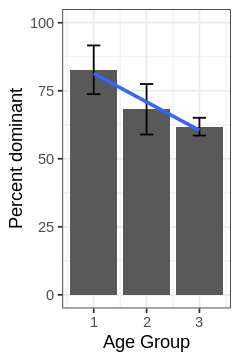

In [29]:
options(repr.plot.width = 2, repr.plot.height = 3)
data_3_lt <- filter(data_paper, experiment_paper == "Experiment 3") %>%
  mutate(age = ifelse(age_group == "young child", 1, ifelse(age_group == "older child", 2, 3)))

# linear trend plot
ggplot(data_3_lt, aes(age, mean)) +
  geom_bar(stat = "identity") +
  geom_errorbar(aes(ymin = mean - se, ymax = mean + se),
                  position = position_dodge(width = 0.9), width = 0.25)+
  stat_smooth(method = "lm", se = F)+
  theme_bw() + 
  xlab("Age Group") +
  ylab("Percent dominant") +
  ylim(0,100)


### Rating
Let's get the mean z-score for each person and the mean for each age group. Then we can recreate Alison's plots to see if we are close.

In [0]:
# mean z-score for each participant
data_60_40 <- data_normed %>% filter(Distribution %in% c("60-40")) %>% group_by(Distribution, age_group, Subject, `Sentence Manipulation`) %>%
  summarise(age = mean(age), mean_rate = mean(z_score))


In [39]:
# mean z-score by age and trial type
data_60_40_z <- data_60_40 %>%
  group_by(Distribution, age_group, `Sentence Manipulation`) %>%
  summarize(n = n(), mean_age = mean(age), mean_z = mean(mean_rate), sd = sd(mean_rate),
      sem = sd(mean_rate)/sqrt(length(mean_rate)))

data_60_40_z %>% kable



|Distribution |age_group   |Sentence Manipulation |  n|  mean_age|     mean_z|        sd|       sem|
|:------------|:-----------|:---------------------|--:|---------:|----------:|---------:|---------:|
|60-40        |adult       |bl                    |  8| 20.580082| -0.9437363| 0.1685691| 0.0595982|
|60-40        |adult       |dom                   |  8| 20.580082|  0.9711531| 0.0548389| 0.0193885|
|60-40        |adult       |min                   |  8| 20.580082|  0.8865777| 0.1353637| 0.0478583|
|60-40        |adult       |nov                   |  8| 20.580082| -0.9139945| 0.1960828| 0.0693258|
|60-40        |older child |bl                    | 12|  7.762948| -0.6186181| 0.4230602| 0.1221270|
|60-40        |older child |dom                   | 12|  7.762948|  0.6353222| 0.3156580| 0.0911226|
|60-40        |older child |min                   | 12|  7.762948|  0.6335129| 0.3674509| 0.1060739|
|60-40        |older child |nov                   | 12|  7.762948| -0.6502170| 0.3433028|

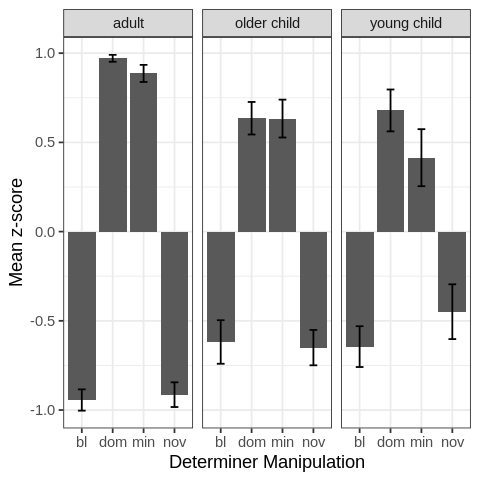

In [40]:
options(repr.plot.width = 4, repr.plot.height = 4)

ggplot(data_60_40_z, aes(x = `Sentence Manipulation`, y = mean_z)) +
  facet_grid(.~age_group) +
  geom_bar(stat = "identity", position = position_dodge()) +
  geom_errorbar(aes(ymin = mean_z - sem, ymax = mean_z + sem),
                  position = position_dodge(width = 0.9), width = 0.25)+
  theme_bw() + 
  xlab("Determiner Manipulation") +
  ylab("Mean z-score") 
  

Sent this plot to Lissa to compare to Alison's and she agreed it was very close. The values of n don't match what is in the paper, but we have no way to easily tell which kids were excluded from the production data (we only have the reported means, unless we re-ran Alison's entire preprocessing).  Lissa and I agreed it's fine to just include all the kids we have in the rating data, provided the plots generated looked close enough to Alison's. They do, so we will use all kids for the stats.

In [48]:
# do a paired ttest comparing dom to min for each age group
data_60_40 %>% 
  filter(`Sentence Manipulation` %in% c("dom", "min")) %>%
  group_by(age_group) %>%
  do(tidy(t.test(mean_rate ~ `Sentence Manipulation`, paired = TRUE, alternative = "two.sided", data = .))) %>%
  kable



|age_group   |  estimate| statistic|   p.value| parameter|   conf.low| conf.high|method        |alternative |
|:-----------|---------:|---------:|---------:|---------:|----------:|---------:|:-------------|:-----------|
|adult       | 0.0845754| 1.5347152| 0.1687272|         7| -0.0457348| 0.2148857|Paired t-test |two.sided   |
|older child | 0.0018093| 0.0188172| 0.9853239|        11| -0.2098208| 0.2134394|Paired t-test |two.sided   |
|young child | 0.2646796| 1.7730366| 0.1099784|         9| -0.0730161| 0.6023752|Paired t-test |two.sided   |

As described in the paper, nobody is significantly different between dom and min

## Experiment 4

### Production

In [60]:
# let's see the data for this experiment
data_paper %>% filter(experiment_paper == "Experiment 4") %>% kable



|experiment_paper |age_group   |condition    |  n| df| mean|        sd|   se|
|:----------------|:-----------|:------------|--:|--:|----:|---------:|----:|
|Experiment 4     |adult       |inconsistent |  8|  7| 44.6|  9.842926| 3.48|
|Experiment 4     |older child |inconsistent | 10|  9| 49.6|  8.190299| 2.59|
|Experiment 4     |young child |inconsistent |  9|  8| 77.4| 21.870000| 7.29|

First, we can do a ttest against the input level for each age group.

In [0]:
# do a one sample ttest against the input for Experiment 4 (input = 40)
exp_4 <- data_paper %>% 
  filter(experiment_paper == "Experiment 4") %>%
  group_by(experiment_paper, age_group, df) %>%
  do(tidy(tsum.test(mean.x = .$mean, 
                    s.x = .$sd, 
                    n.x = .$n,
                    mu = 40,
                    alternative = 'greater'))) 

In [64]:
# summarize results of ttest in a table
exp_4 %>% kable



|experiment_paper |age_group   | df| estimate| statistic|   p.value| conf.low| conf.high|method            |alternative |
|:----------------|:-----------|--:|--------:|---------:|---------:|--------:|---------:|:-----------------|:-----------|
|Experiment 4     |adult       |  7|     44.6|  1.321839| 0.1138900| 38.00687|        NA|One-sample t-Test |greater     |
|Experiment 4     |older child |  9|     49.6|  3.706564| 0.0024354| 44.85224|        NA|One-sample t-Test |greater     |
|Experiment 4     |young child |  8|     77.4|  5.130316| 0.0004479| 63.84389|        NA|One-sample t-Test |greater     |

Next, we can compare the older children to the younger kids and adults

In [0]:
# get the values for each group
exp4_older <- filter(data_paper, experiment_paper == "Experiment 4", age_group == "older child")
exp4_young <- filter(data_paper, experiment_paper == "Experiment 4", age_group == "young child")
exp4_adult <- filter(data_paper, experiment_paper == "Experiment 4", age_group == "adult")

In [67]:
# compare older kids to adults (are they signifianctly more than older?)
tidy(tsum.test(mean.x = exp4_older$mean, s.x = exp4_older$sd, n.x = exp4_older$n,
               mean.y = exp4_adult$mean, s.y = exp4_adult$sd, n.y = exp4_adult$n,
               alternative = 'greater')) %>% kable



| estimate1| estimate2| statistic|   p.value|  conf.low| conf.high|method                           |alternative |
|---------:|---------:|---------:|---------:|---------:|---------:|:--------------------------------|:-----------|
|      49.6|      44.6|  1.152597| 0.1344338| -2.654643|        NA|Welch Modified Two-Sample t-Test |greater     |

In [68]:
# compare older kids to younger kids (are they significantly less than younger?)
tidy(tsum.test(mean.x = exp4_older$mean, s.x = exp4_older$sd, n.x = exp4_older$n,
               mean.y = exp4_young$mean, s.y = exp4_young$sd, n.y = exp4_young$n,
               alternative = 'less')) %>% kable



| estimate1| estimate2| statistic|   p.value| conf.low| conf.high|method                           |alternative |
|---------:|---------:|---------:|---------:|--------:|---------:|:--------------------------------|:-----------|
|      49.6|      77.4| -3.593393| 0.0024486|       NA|  -13.7788|Welch Modified Two-Sample t-Test |less        |

Lissa asked for a linear trend here, but this really isn't possible with just means and sd. I plotted the data and included a linear trend line, but it doesn't tell us really anything and we don't have any stats about this. It tells us usaged of the dominant form goes down over age, but that isn't necessarily driven by the older kids (the same would be true without them).

The error bars and above ttests also tell you that the older kids are significantly different from the adults or younger kids. There are a very small number of kids in these experiments (7 older and 7 younger) so that makes it even harder to tell.

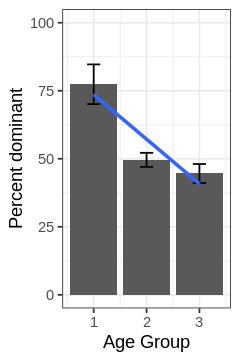

In [69]:
options(repr.plot.width = 2, repr.plot.height = 3)
data_4_lt <- filter(data_paper, experiment_paper == "Experiment 4") %>%
  mutate(age = ifelse(age_group == "young child", 1, ifelse(age_group == "older child", 2, 3)))

# linear trend plot
ggplot(data_4_lt, aes(age, mean)) +
  geom_bar(stat = "identity") +
  geom_errorbar(aes(ymin = mean - se, ymax = mean + se),
                  position = position_dodge(width = 0.9), width = 0.25)+
  stat_smooth(method = "lm", se = F)+
  theme_bw() + 
  xlab("Age Group") +
  ylab("Percent dominant") +
  ylim(0,100)


### Rating
Let's get the mean z-score for each person and the mean for each age group. Then we can recreate Alison's plots to see if we are close.

In [0]:
# mean z-score for each participant
data_40_20_4 <- data_normed %>% filter(Distribution %in% c("40-20-4")) %>% group_by(Distribution, age_group, Subject, `Sentence Manipulation`) %>%
  summarise(age = mean(age), mean_rate = mean(z_score))


It turns out that many if the kids (especially in the older child group) got an incorrect, old version of the rating test (one with only 4 trial types: corr, missing, novel, wo). We decided to just eliminate those kids from the rating analysis and instead include only the kids who did the version of the rating test that is described in the paper. This means only 2 older kids are included, but as you'll see, the plots later look a lot like Alison's, so this is probably what she did also.

In [54]:
# mean z-score by age and trial type (for kids who got the right test)
data_40_20_4_z <- data_40_20_4 %>%
  filter(`Sentence Manipulation` %in% c('bl', 'dom', 'min', 'nov', 'scat')) %>% 
  group_by(Distribution, age_group, `Sentence Manipulation`) %>%
  summarize(n = n(), mean_age = mean(age), mean_z = mean(mean_rate), sd = sd(mean_rate),
      sem = sd(mean_rate)/sqrt(length(mean_rate)))

data_40_20_4_z %>% kable



|Distribution |age_group   |Sentence Manipulation |  n|  mean_age|     mean_z|        sd|       sem|
|:------------|:-----------|:---------------------|--:|---------:|----------:|---------:|---------:|
|40-20-4      |adult       |bl                    |  8| 20.274812| -1.1846230| 0.1138203| 0.0402416|
|40-20-4      |adult       |dom                   |  8| 20.274812|  0.7741400| 0.1278024| 0.0451850|
|40-20-4      |adult       |min                   |  8| 20.274812|  0.7883660| 0.1529653| 0.0540814|
|40-20-4      |adult       |nov                   |  8| 20.274812| -0.8295349| 0.1796477| 0.0635150|
|40-20-4      |adult       |scat                  |  8| 20.274812|  0.4516520| 0.2498572| 0.0883378|
|40-20-4      |older child |bl                    |  2|  8.062971| -1.0315803| 0.1495675| 0.1057602|
|40-20-4      |older child |dom                   |  2|  8.062971|  0.7080911| 0.2158076| 0.1525990|
|40-20-4      |older child |min                   |  2|  8.062971|  0.8932551| 0.0460539|

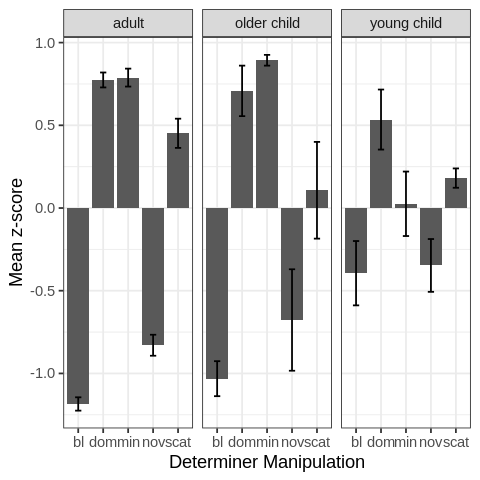

In [55]:
options(repr.plot.width = 4, repr.plot.height = 4)

ggplot(data_40_20_4_z, aes(x = `Sentence Manipulation`, y = mean_z)) +
  facet_grid(.~age_group) +
  geom_bar(stat = "identity", position = position_dodge()) +
  geom_errorbar(aes(ymin = mean_z - sem, ymax = mean_z + sem),
                  position = position_dodge(width = 0.9), width = 0.25)+
  theme_bw() + 
  xlab("Determiner Manipulation") +
  ylab("Mean z-score") 
  

As in Experiment 3, I sent this plot for Experiment 4 to Lissa to compare to Alison's and she agreed it was very close. The values of n don't match what is in the paper, but we have no way to easily tell which kids were excluded from the production data (we only have the reported means, unless we re-ran Alison's entire preprocessing).  Lissa and I agreed it's fine to just include all the kids we have in the rating data, provided the plots generated looked close enough to Alison's. They do, so we will use all kids for the stats.

In [56]:
# Is dominant different from minority?
# do a paired ttest comparing dom to min for each age group
data_40_20_4 %>% 
  filter(`Sentence Manipulation` %in% c("dom", "min")) %>%
  group_by(age_group) %>%
  do(tidy(t.test(mean_rate ~ `Sentence Manipulation`, paired = TRUE, alternative = "two.sided", data = .))) %>%
  kable



|age_group   |   estimate|  statistic|   p.value| parameter|   conf.low| conf.high|method        |alternative |
|:-----------|----------:|----------:|---------:|---------:|----------:|---------:|:-------------|:-----------|
|adult       | -0.0142260| -0.1756274| 0.8655592|         7| -0.2057629| 0.1773109|Paired t-test |two.sided   |
|older child | -0.1851640| -1.0000000| 0.5000000|         1| -2.5378960| 2.1675679|Paired t-test |two.sided   |
|young child |  0.5093423|  2.7408781| 0.0288816|         7|  0.0699199| 0.9487646|Paired t-test |two.sided   |

As described in the paper, nobody is significantly different between dom and min

In [58]:
# Is scatter different from minority?
# do a paired ttest comparing min to scat for each age group
data_40_20_4 %>% 
  filter(`Sentence Manipulation` %in% c("min", "scat")) %>%
  group_by(age_group) %>%
  do(tidy(t.test(mean_rate ~ `Sentence Manipulation`, paired = TRUE, alternative = "two.sided", data = .))) %>%
  kable



|age_group   |   estimate|  statistic|   p.value| parameter|   conf.low| conf.high|method        |alternative |
|:-----------|----------:|----------:|---------:|---------:|----------:|---------:|:-------------|:-----------|
|adult       |  0.3367140|  2.6646170| 0.0322504|         7|  0.0379086| 0.6355195|Paired t-test |two.sided   |
|older child |  0.7860340|  2.4189379| 0.2495603|         1| -3.3428482| 4.9149162|Paired t-test |two.sided   |
|young child | -0.1554004| -0.6942442| 0.5099059|         7| -0.6847007| 0.3738998|Paired t-test |two.sided   |